In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
import findspark

#init spark session
findspark.init()
conf = SparkConf().setAppName("myFirstApp").setMaster("local")
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [3]:
# #get file from hdfs
spark_df = sqlContext.read.csv("hdfs://192.168.99.100:9000/user/root/input/Data_USD_VND.csv",header=True)

'local-1603857467408'

In [3]:
from functools import reduce
#format column name
oldColumns = spark_df.schema.names
newColumns = ["date", "close","open","high","low","change"]

df = reduce(
    lambda spark_df, idx: spark_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), 
    range(len(oldColumns)), spark_df)

In [4]:
from pyspark.sql.functions import regexp_replace

#remove commas and %
def remove_some_chars(col_name):
    removed_chars = (",", "%")
    regexp = "|".join('\{0}'.format(i) for i in removed_chars)
    return regexp_replace(col_name, regexp, "")

In [5]:
new_df = (reduce(
    lambda memo_df, col_name: 
        memo_df.withColumn(col_name, remove_some_chars(col_name)),
    ["close", "open","high","low","change"],df))

In [6]:
changedTypedf = (reduce(
    lambda memo_df, col_name: 
        memo_df.withColumn(col_name, memo_df[col_name].cast('float')),
    ["close", "open","high","low","change"],new_df))
changedTypedf.dtypes

[('date', 'string'),
 ('close', 'float'),
 ('open', 'float'),
 ('high', 'float'),
 ('low', 'float'),
 ('change', 'float')]

In [7]:
rows = changedTypedf.count()
print("number of original rows: ",rows)
rowsAfterDel = changedTypedf.dropDuplicates().count()
print("number of rows after deleted: ",rowsAfterDel)
rowsDel = rows - rowsAfterDel
print("number of deleted row: ",rowsDel)

number of original rows:  5000
number of rows after deleted:  5000
number of deleted row:  0


In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pandas_df = changedTypedf.toPandas()
pandas_df.sort_values("date")

,date,close,open,high,low,change
4280,1/1/2003,15401.0,15396.0,15401.0,15396.0,0.00
3238,1/1/2007,16056.0,16051.0,16056.0,16051.0,0.00
2977,1/1/2008,16028.0,16018.0,16028.0,16018.0,0.00
2715,1/1/2009,17483.0,17480.0,17483.0,17480.0,0.00
2454,1/1/2010,18474.0,18469.0,18474.0,18469.0,0.00
...,...,...,...,...,...,...
2014,9/9/2011,20817.0,20830.0,20849.0,20750.0,0.00
1493,9/9/2013,21140.0,21100.0,21150.0,21080.0,-0.07
1232,9/9/2014,21200.0,21175.0,21230.0,21160.0,0.02
971,9/9/2015,22480.0,22484.0,22494.0,22450.0,-0.29


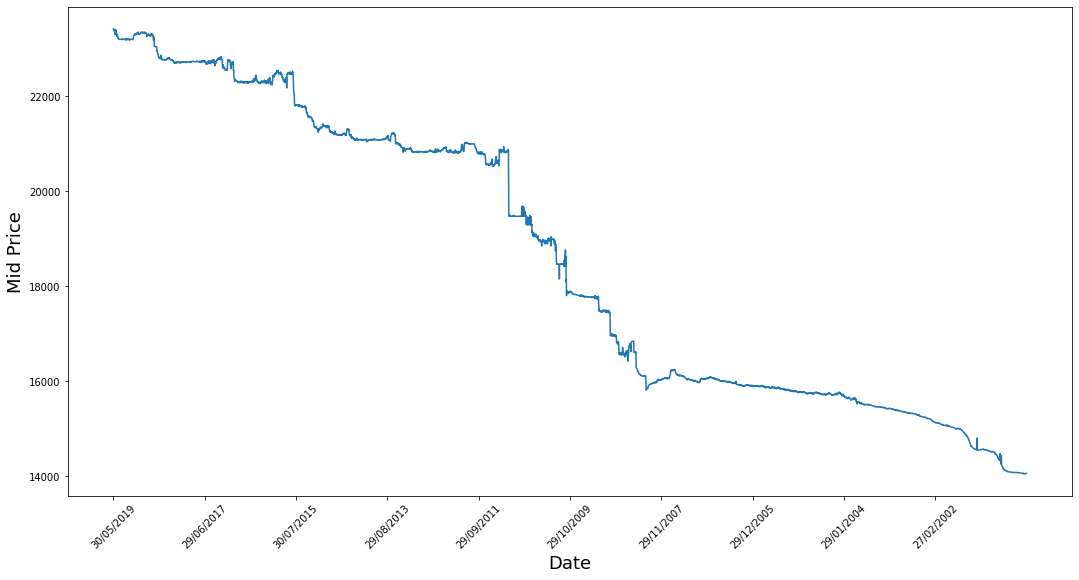

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(pandas_df.shape[0]),(pandas_df['low']+pandas_df['high'])/2.0)
plt.xticks(range(0,pandas_df.shape[0],500),pandas_df['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [10]:
high_prices = pandas_df.loc[:,'high'].to_numpy()
low_prices = pandas_df.loc[:,'low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

test_data = mid_prices[:900]
print(test_data.size,test_data)
train_data = mid_prices[900:]

900 [23415.   23402.   23391.   23389.5  23393.5  23380.   23390.   23389.
 23410.   23369.   23298.5  23350.5  23365.   23329.   23367.5  23395.
 23343.   23322.   23281.5  23260.5  23266.   23290.   23290.   23290.
 23257.5  23246.5  23219.   23221.5  23212.5  23208.   23201.   23198.
 23200.   23199.5  23197.5  23197.5  23197.5  23197.5  23199.5  23195.5
 23199.5  23198.5  23199.   23202.   23200.5  23200.   23197.5  23198.
 23199.   23202.   23202.5  23194.5  23210.   23205.   23201.5  23201.
 23197.5  23198.   23197.5  23197.5  23198.5  23198.5  23199.   23198.5
 23192.   23192.5  23197.   23206.   23195.   23218.5  23206.5  23197.
 23197.5  23181.   23200.5  23200.   23204.5  23206.   23202.5  23207.5
 23207.5  23207.5  23207.5  23207.5  23202.5  23198.5  23200.   23195.5
 23175.   23195.5  23198.   23199.   23197.75 23198.   23200.75 23199.
 23199.5  23200.   23198.   23196.   23196.   23196.5  23195.   23197.5
 23197.   23199.   23200.   23195.   23195.   23210.   23252.5  2327

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(1,-1)
print(test_data)

smoothing_window_size = 1000
for di in range(0,4000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])


scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

[[23415.   23402.   23391.   23389.5  23393.5  23380.   23390.   23389.
  23410.   23369.   23298.5  23350.5  23365.   23329.   23367.5  23395.
  23343.   23322.   23281.5  23260.5  23266.   23290.   23290.   23290.
  23257.5  23246.5  23219.   23221.5  23212.5  23208.   23201.   23198.
  23200.   23199.5  23197.5  23197.5  23197.5  23197.5  23199.5  23195.5
  23199.5  23198.5  23199.   23202.   23200.5  23200.   23197.5  23198.
  23199.   23202.   23202.5  23194.5  23210.   23205.   23201.5  23201.
  23197.5  23198.   23197.5  23197.5  23198.5  23198.5  23199.   23198.5
  23192.   23192.5  23197.   23206.   23195.   23218.5  23206.5  23197.
  23197.5  23181.   23200.5  23200.   23204.5  23206.   23202.5  23207.5
  23207.5  23207.5  23207.5  23207.5  23202.5  23198.5  23200.   23195.5
  23175.   23195.5  23198.   23199.   23197.75 23198.   23200.75 23199.
  23199.5  23200.   23198.   23196.   23196.   23196.5  23195.   23197.5
  23197.   23199.   23200.   23195.   23195.   23210.   232

In [12]:
# Reshape both train and test data
print(train_data)
train_data = train_data.reshape(-1)
print("BEFORE:",test_data)
# # Normalize test data
scaler.fit(test_data)
test_data = scaler.transform(test_data).reshape(-1)
print("AFTER:",test_data)

[[0.9921112 ]
 [0.99411964]
 [1.        ]
 ...
 [0.14202881]
 [0.11361694]
 [0.1875    ]]
BEFORE: [[23415.   23402.   23391.   23389.5  23393.5  23380.   23390.   23389.
  23410.   23369.   23298.5  23350.5  23365.   23329.   23367.5  23395.
  23343.   23322.   23281.5  23260.5  23266.   23290.   23290.   23290.
  23257.5  23246.5  23219.   23221.5  23212.5  23208.   23201.   23198.
  23200.   23199.5  23197.5  23197.5  23197.5  23197.5  23199.5  23195.5
  23199.5  23198.5  23199.   23202.   23200.5  23200.   23197.5  23198.
  23199.   23202.   23202.5  23194.5  23210.   23205.   23201.5  23201.
  23197.5  23198.   23197.5  23197.5  23198.5  23198.5  23199.   23198.5
  23192.   23192.5  23197.   23206.   23195.   23218.5  23206.5  23197.
  23197.5  23181.   23200.5  23200.   23204.5  23206.   23202.5  23207.5
  23207.5  23207.5  23207.5  23207.5  23202.5  23198.5  23200.   23195.5
  23175.   23195.5  23198.   23199.   23197.75 23198.   23200.75 23199.
  23199.5  23200.   23198.   23196

In [13]:

# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(4100):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [14]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []
import datetime as dtime

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dtime.datetime.strptime(k, '%Y/%m/%d').date() + dtime.timedelta(days=1)
    else:
        date = pandas_df.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01108


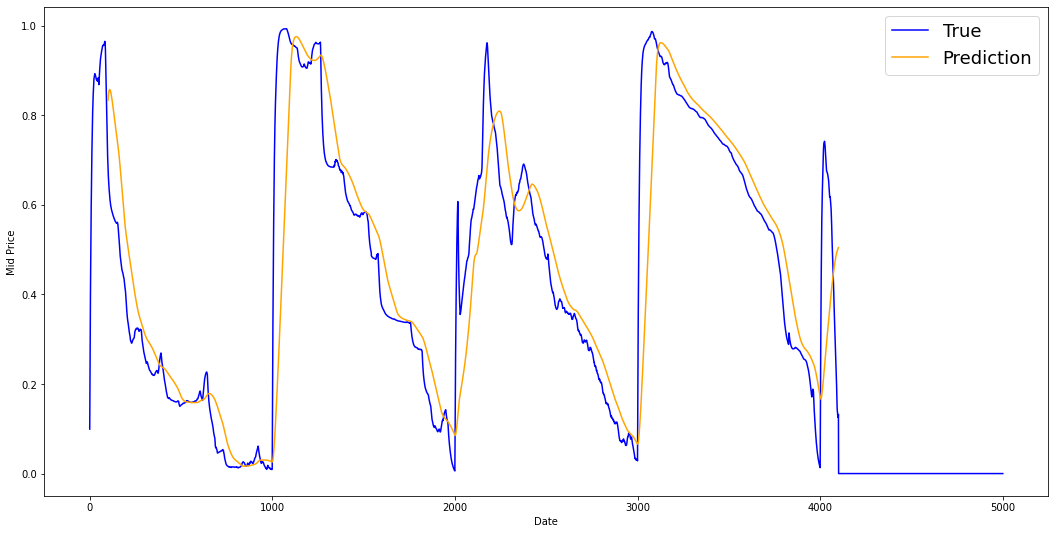

In [15]:
plt.figure(figsize = (18,9))
plt.plot(range(pandas_df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [16]:
changedTypedf.dtypes

[('date', 'string'),
 ('close', 'float'),
 ('open', 'float'),
 ('high', 'float'),
 ('low', 'float'),
 ('change', 'float')]

In [17]:
import logging
from cassandra.cluster import Cluster


logging.basicConfig(level=logging.INFO)


def cassandra_connection():
    """
    Connection object for Cassandra
    :return: session, cluster
    """
    cluster = Cluster(['192.168.99.100'], port=9042,protocol_version = 4,load_balancing_policy=None)
    session = cluster.connect()
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS test
        WITH REPLICATION =
        { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }
        """)
    session.set_keyspace('test')
    return cluster, session

print(cassandra_connection());

INFO:cassandra.policies:Using datacenter 'datacenter' for DCAwareRoundRobinPolicy (via host '192.168.99.100:9042'); if incorrect, please specify a local_dc to the constructor, or limit contact points to local cluster nodes


(<cassandra.cluster.Cluster object at 0x7feed2d9f748>, <cassandra.cluster.Session object at 0x7feecf2dc7f0>)


In [18]:
cluster,session = cassandra_connection()
qry= '''
create table result (
   date text,
   close float,
   open float,
   high float,
   low float,
   change float,
   primary key(date)
);'''
session.execute(qry)

INFO:cassandra.policies:Using datacenter 'datacenter' for DCAwareRoundRobinPolicy (via host '192.168.99.100:9042'); if incorrect, please specify a local_dc to the constructor, or limit contact points to local cluster nodes


In [19]:
insertQuery = "INSERT INTO result(date,close,open,high,low,change) VALUES (?,?,?,?,?,?)"
prepared = session.prepare(insertQuery)
print(len(pandas_df))
for i in range(len(pandas_df)):
    session.execute(prepared, (pandas_df.date[i],pandas_df.close[i],
                               pandas_df.open[i],pandas_df.high[i],
                               pandas_df.low[i],pandas_df.change[i]))

5000
